# Projet HEC - Legal Data Analytics

In [1]:
from os import path
from selenium import webdriver
from selenium.webdriver.common.by import By

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import regex as re

## 1. Scraping de QPC360

Nous allons réaliser le scraping séparément pour les trois juridictions considérées : le Conseil Constitutionnel, le Conseil d'État, et la Cour de Cassation.

In [2]:
cons_cons = 'https://qpc360.conseil-constitutionnel.fr/recherche/jurisprudence?f%5B0%5D=juridiction%3A1'
cons_etat = 'https://qpc360.conseil-constitutionnel.fr/recherche/jurisprudence?f%5B0%5D=juridiction%3A3'
cour_cass = 'https://qpc360.conseil-constitutionnel.fr/recherche/jurisprudence?f%5B0%5D=juridiction%3A122'

driver = webdriver.Chrome()

La première étape est de scraper les liens de toutes les décisions pour chaque juridiction.

Nous parcourons donc chaque page de la liste et récupérons tous les liens jusqu'à arriver sur une page vide.

In [3]:
def scrap_links(jurisdiction):
    
    page, count, links = -1, 1, []
    
    while count > 0:
        page += 1
        
        driver.get(jurisdiction + '&page=' + str(page))
        elements = driver.find_elements(By.CLASS_NAME, 'search-case-law__row') # S1
        count = len(elements)
        
        for element in elements:
            links += [element.find_element(By.TAG_NAME, 'a').get_attribute('href').split('?searchParams')[0]] # S2
    
    return links

In [4]:
links_cons_cons = scrap_links(cons_cons)
links_cons_etat = scrap_links(cons_etat)
links_cour_cass = scrap_links(cour_cass)

La seconde étape consiste à récupérer pour chaque lien de chaque juridiction les informations nécessaires à notre étude ultérieure.

Nous scrapons ainsi les informations suivantes : date de la décision, solution apportée par la juridiction, matière du droit concernée, ainsi que les articles du bloc de constitutionnalité utilisés. Nous récupérons également l'origine du renvoi pour les décisions du Conseil Constitutionnel.

Nous stockons toutes ces données dans un dataframe qui sera utilisable par la suite.

In [5]:
def build_dataframe(links, origin_column):
    
    columns = ['DATE', 'SOLUTION', 'MATIERE', 'DECLARATION', 'CONSTITUTION', 'PREAMBULE']
    if origin_column: columns += ['ORIGINE']
    
    dataframe = pd.DataFrame(columns = columns).rename_axis('LIEN')
    
    for link in links:
        driver.get(link)
        
        date = driver.find_element(By.CLASS_NAME, 'date').text # S3
        
        try:
            solution = driver.find_element(By.CLASS_NAME, 'dqpc__qpc-solution.field--entity-reference').text # S4
        except:
            solution = 'N/A'
        
        try:
            matiere = driver.find_element(By.CLASS_NAME, 'dqpc__dqpc-matiere.field--entity-reference').text # S5
        except:
            matiere = 'N/A'
        
        texte = driver.find_element(By.CLASS_NAME, 'dqpc__dqpc-texte.field--text-long.contrib').text # S6
        
        declaration = re.findall(r'article \w* de la Déclaration', texte, flags = re.I)
        constitution = re.findall(r'article \w* de la Constitution', texte, flags = re.I)
        preambule = re.findall(r'\w* alinéa du Préambule', texte, flags = re.I)
        
        declaration = list(set([x.split(' ')[1] for x in declaration]))
        constitution = list(set([x.split(' ')[1] for x in constitution]))
        preambule = list(set([x.split(' ')[0] for x in preambule]))
        
        if origin_column:
            parcours = driver.find_elements(By.CLASS_NAME, 'jurisdictional-course-step__link') # S7
            
            if len(parcours) == 2:
                origine = parcours[1].find_element(By.TAG_NAME, 'a').get_attribute('href')
            else:
                origine = 'N/A'
        
        values = [date, solution, matiere, declaration, constitution, preambule]
        if origin_column: values += [origine]
        
        dataframe.loc[link] = values
    
    return dataframe

In [8]:
data_cons_cons = build_dataframe(links_cons_cons, origin_column = True)
data_cons_etat = build_dataframe(links_cons_etat, origin_column = False)
data_cour_cass = build_dataframe(links_cour_cass, origin_column = False)

Nous pouvons visualiser par exemple le dataframe du Conseil Constitutionnel.

In [9]:
data_cons_cons

,DATE,SOLUTION,MATIERE,DECLARATION,CONSTITUTION,PREAMBULE,ORIGINE
LIEN,,,,,,,
https://qpc360.conseil-constitutionnel.fr/2018-07-13/decision-2018-720721722723724725726-qpc-13-juillet-2018,13/07/2018,Non-conformité totale,N/A,[],"[62, 1er, 34]",[huitième],N/A
https://qpc360.conseil-constitutionnel.fr/2016-10-05/decision-2016-574575576577578-qpc-5-octobre-2016,05/10/2016,Conformité,N/A,"[2, 17]",[],[],N/A
https://qpc360.conseil-constitutionnel.fr/2021-01-21/decision-2020-874875876877-qpc-21-janvier-2021,21/01/2021,Conformité,N/A,[],[34],[dixième],N/A
https://qpc360.conseil-constitutionnel.fr/2021-06-04/decision-2021-912913914-qpc-4-juin-2021,04/06/2021,N/A,N/A,[],"[62, 66, 34]",[],N/A
https://qpc360.conseil-constitutionnel.fr/2020-06-26/decision-2020-846847848-qpc-26-juin-2020,26/06/2020,Conformité,N/A,[8],[34],[],N/A
...,...,...,...,...,...,...,...
https://qpc360.conseil-constitutionnel.fr/2011-05-13/decision-2011-126-qpc-13-mai-2011,13/05/2011,N/A,Economie,"[2, 16, 4]",[],[],N/A
https://qpc360.conseil-constitutionnel.fr/2015-11-20/decision-2015-497-qpc-20-novembre-2015,20/11/2015,N/A,Social,"[13, 6]",[],[],N/A
https://qpc360.conseil-constitutionnel.fr/2021-03-19/decision-2021-891-qpc-19-mars-2021,19/03/2021,Non-conformité totale,Environnement,[],[62],[],https://qpc360.conseil-constitutionnel.fr/2020...


## 2. Mise en forme des données

### 2.1 Lien entre décisions

In [10]:
presence_origine = (data_cons_cons['ORIGINE'] != 'N/A').sum() / len(data_cons_cons)
print(f'{100 * presence_origine:0.2f}%')

24.89%


La juridiction d'origine de la décision de renvoi n'est indiquée dans la base de données que pour un quart des décisions du Conseil Constitutionnel. Nous ne chercherons donc pas à lier les décisions du Conseil Constitutionnel à celles du Conseil d'État ou de la Cour de Cassation, et analyserons l'ensemble des décisions de manière indépendante.

In [11]:
data_cons_cons = data_cons_cons.drop('ORIGINE', axis = 1)

### 2.2 Uniformisation des solutions

In [12]:
display(data_cons_cons['SOLUTION'].value_counts())
display(data_cons_etat['SOLUTION'].value_counts())
display(data_cour_cass['SOLUTION'].value_counts())

Conformité                           486
N/A                                  250
Non-conformité totale                124
Non-conformité partielle              39
Non-lieu à statuer                    24
Rejet                                 10
Rectification d'erreur matérielle      3
Non-conformité de date à date          2
Décision avant dire droit              1
Réserve                                1
Name: SOLUTION, dtype: int64

Renvoi                132
Non renvoi            115
Irrecevabilité         34
Renvoi partiel         29
Autre                   5
Non-lieu à statuer      2
N/A                     1
Name: SOLUTION, dtype: int64

Non renvoi        204
Renvoi            170
Irrecevabilité     20
Renvoi partiel     10
N/A                 8
Autre               2
Désistement         1
Name: SOLUTION, dtype: int64

Pour chaque juridiction, nous observons un nombre important de solutions possibles qui pourraient brouiller l'analyse si laissées telles quelles.

Nous allons donc réduire ce nombre en groupant les solutions.

In [13]:
data_cons_cons = data_cons_cons.replace({'SOLUTION': {'Non-conformité totale': 'Non-conformité',
                                                      'Non-conformité partielle': 'Non-conformité',
                                                      'Non-lieu à statuer': 'Conformité',
                                                      'Rejet': 'Conformité',
                                                      'Rectification d\'erreur matérielle': 'N/A',
                                                      'Non-conformité de date à date': 'Non-conformité',
                                                      'Décision avant dire droit': 'N/A',
                                                      'Réserve': 'Conformité'}})

data_cons_etat = data_cons_etat.replace({'SOLUTION': {'Irrecevabilité': 'Non renvoi',
                                                      'Renvoi partiel': 'Renvoi',
                                                      'Rejet': 'Non renvoi',
                                                      'Autre': 'N/A',
                                                      'Non-lieu à statuer': 'Non renvoi'}})

data_cour_cass = data_cour_cass.replace({'SOLUTION': {'Irrecevabilité': 'Non renvoi',
                                                      'Renvoi partiel': 'Renvoi',
                                                      'Autre': 'N/A',
                                                      'Désistement': 'Non renvoi'}})

In [14]:
display(data_cons_cons['SOLUTION'].value_counts())
display(data_cons_etat['SOLUTION'].value_counts())
display(data_cour_cass['SOLUTION'].value_counts())

Conformité        521
N/A               254
Non-conformité    165
Name: SOLUTION, dtype: int64

Renvoi        161
Non renvoi    151
N/A             6
Name: SOLUTION, dtype: int64

Non renvoi    225
Renvoi        180
N/A            10
Name: SOLUTION, dtype: int64

### 2.3 Répartitions des décisions

Afin d'avoir une meilleure compréhension des données, nous commençons par simplement afficher des graphiques indiquant la répartition des décisions par solution et par matière pour chaque juridiction.

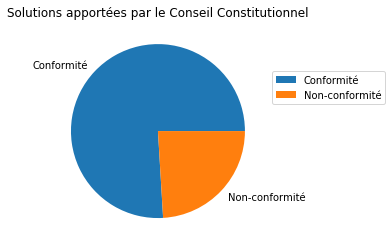

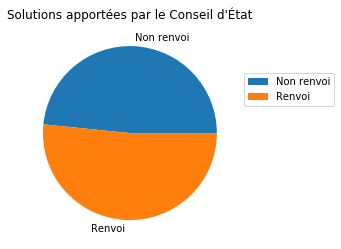

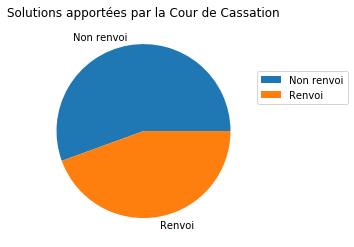

In [15]:
data_cons_cons['SOLUTION'].value_counts().reindex(['Conformité', 'Non-conformité']).plot.pie()
plt.title('Solutions apportées par le Conseil Constitutionnel')
plt.legend(loc = 'upper left', bbox_to_anchor = (1.0, 0.8))
plt.ylabel('')
plt.show()

data_cons_etat['SOLUTION'].value_counts().reindex(['Non renvoi', 'Renvoi']).plot.pie()
plt.title('Solutions apportées par le Conseil d\'État')
plt.legend(loc = 'upper left', bbox_to_anchor = (1.0, 0.8))
plt.ylabel('')
plt.show()

data_cour_cass['SOLUTION'].value_counts().reindex(['Non renvoi', 'Renvoi']).plot.pie()
plt.title('Solutions apportées par la Cour de Cassation')
plt.legend(loc = 'upper left', bbox_to_anchor = (1.0, 0.8))
plt.ylabel('')
plt.show()

Nous observons une différence significative de la probabilité de succès de la demande en fonction de la juridiction : le Conseil d'État et la Cour de Cassation renvoient environ la moitié des demandes au Conseil Constitutionnel, mais celui-ci ne déclare une non-conformité que pour environ un quart de celles-ci (soit donc environ un huitième des demandes initiales).

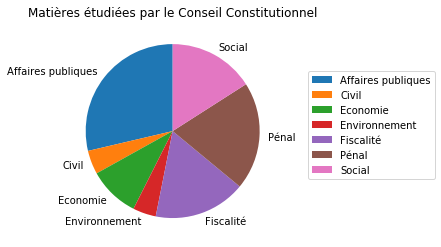

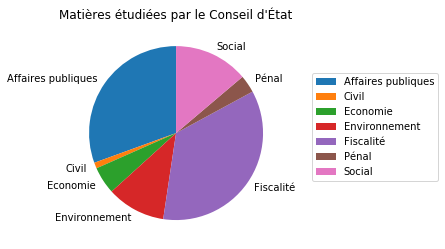

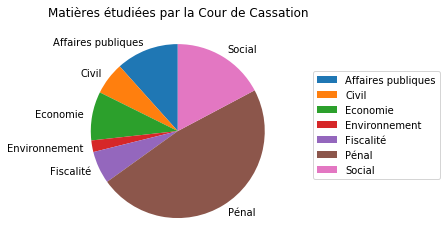

In [16]:
data_cons_cons['MATIERE'].value_counts().drop('N/A').sort_index().plot.pie(startangle = 90)
plt.title('Matières étudiées par le Conseil Constitutionnel')
plt.legend(loc = 'upper left', bbox_to_anchor = (1.1, 0.8))
plt.ylabel('')
plt.show()

data_cons_etat['MATIERE'].value_counts().drop('N/A').sort_index().plot.pie(startangle = 90)
plt.title('Matières étudiées par le Conseil d\'État')
plt.legend(loc = 'upper left', bbox_to_anchor = (1.1, 0.8))
plt.ylabel('')
plt.show()

data_cour_cass['MATIERE'].value_counts().drop('N/A').sort_index().plot.pie(startangle = 90)
plt.title('Matières étudiées par la Cour de Cassation')
plt.legend(loc = 'upper left', bbox_to_anchor = (1.1, 0.8))
plt.ylabel('')
plt.show()

Nous observons que les demandes sont adressées de manière non uniforme aux différentes juridictions, ce qui est cohérent avec leurs domaines de compétences respectifs.

### 2.4 Évolution temporelle

Nous changeons la mise en forme des données pour les indexer par dates plutôt que par liens, ce qui permettra d'analyser l'évolution de certaines quantités au cours du temps.

In [17]:
data_cons_cons['DATE'] = pd.to_datetime(data_cons_cons['DATE'], format = '%d/%m/%Y')
data_cons_cons = data_cons_cons.reset_index().set_index('DATE').sort_index()

data_cons_etat['DATE'] = pd.to_datetime(data_cons_etat['DATE'], format = '%d/%m/%Y')
data_cons_etat = data_cons_etat.reset_index().set_index('DATE').sort_index()

data_cour_cass['DATE'] = pd.to_datetime(data_cour_cass['DATE'], format = '%d/%m/%Y')
data_cour_cass = data_cour_cass.reset_index().set_index('DATE').sort_index()

Nous pouvons visualiser par exemple le dataframe du Conseil Constitutionnel.

In [18]:
data_cons_cons

,LIEN,SOLUTION,MATIERE,DECLARATION,CONSTITUTION,PREAMBULE
DATE,,,,,,
2010-05-28,https://qpc360.conseil-constitutionnel.fr/2010...,Conformité,Social,"[11, 6]",[],[]
2010-05-28,https://qpc360.conseil-constitutionnel.fr/2010...,N/A,Affaires publiques,"[15, 6]",[],[]
2010-06-11,https://qpc360.conseil-constitutionnel.fr/2010...,Non-conformité,Affaires publiques,[8],[],[]
2010-06-11,https://qpc360.conseil-constitutionnel.fr/2010...,Non-conformité,Social,"[16, 4, 6]",[34],[]
2010-06-18,https://qpc360.conseil-constitutionnel.fr/2010...,Conformité,Fiscalité,[14],[34],[]
...,...,...,...,...,...,...
2023-01-27,https://qpc360.conseil-constitutionnel.fr/2023...,Conformité,Affaires publiques,[16],[],[]
2023-02-10,https://qpc360.conseil-constitutionnel.fr/2023...,Conformité,Pénal,"[9, 16]",[62],[]
2023-02-10,https://qpc360.conseil-constitutionnel.fr/2023...,Conformité,Economie,[16],[],[]


Nous affichons le nombre de décisions traitées par chaque juridiction au cours du temps.

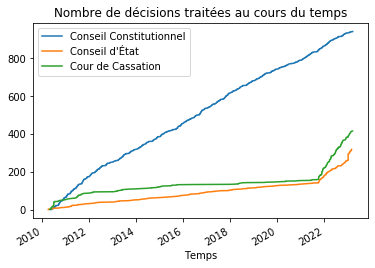

In [19]:
data_cons_cons.expanding().count()['LIEN'].plot(label = 'Conseil Constitutionnel')
data_cons_etat.expanding().count()['LIEN'].plot(label = 'Conseil d\'État')
data_cour_cass.expanding().count()['LIEN'].plot(label = 'Cour de Cassation')
plt.title('Nombre de décisions traitées au cours du temps')
plt.xlabel('Temps')
plt.legend()
plt.show()

Il semble à première vue que le Conseil d'État et la Cour de Cassation n'ont pas mis à jour les décisions durant une longue période, et ont repris l'enregistrement des décisions en 2021. Cela signifie que notre base de données pour ces juridictions n'est pas exhaustive, et particulièrement biaisée en faveur des dernières années. En revanche, les décisions du Conseil Constitutionnel semblent uniformément réparties sur la période.

### 2.5 Bloc de constitutionnalité

Nous changeons la mise en forme du bloc de constitutionnalité afin d'avoir une colonne pour chaque article de chaque texte de référence, avec un 1 si l'article est cité dans la décision et un 0 sinon.

In [20]:
data_totale = data_cons_cons.append(data_cons_etat).append(data_cour_cass)

art_declaration = pd.DataFrame(data_totale['DECLARATION'].to_list())
art_declaration = list(set(np.concatenate([art_declaration[column].dropna().unique()
                                                for column in art_declaration.columns])))

art_declaration = np.sort([int(x) if x != '1er' else 1 for x in art_declaration])
art_declaration = [str(x) if x != 1 else '1er' for x in art_declaration]

art_constitution = pd.DataFrame(data_totale['CONSTITUTION'].to_list())
art_constitution = list(set(np.concatenate([art_constitution[column].dropna().unique()
                                                for column in art_constitution.columns])))

art_constitution = np.sort([int(x) if x != '1er' else 1 for x in art_constitution])
art_constitution = [str(x) if x != 1 else '1er' for x in art_constitution]

art_preambule = ['troisième', 'quatrième', 'cinquième', 'sixième', '8ème', 'huitième',
                 'neuvième', 'dixième', 'onzième', 'douzième', 'treizième']

print(art_declaration)
print(art_constitution)
print(art_preambule)

['1er', '2', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '19']
['1er', '2', '3', '4', '5', '7', '13', '16', '19', '20', '22', '23', '25', '34', '35', '37', '38', '55', '58', '59', '61', '62', '64', '65', '66', '72', '73', '74', '76', '77', '92']
['troisième', 'quatrième', 'cinquième', 'sixième', '8ème', 'huitième', 'neuvième', 'dixième', 'onzième', 'douzième', 'treizième']


In [21]:
def build_articles(data):
    
    data['MOYENNE'] = 1
    
    for art in art_declaration:
        data['DECLARATION_' + art] = data['DECLARATION'].apply(lambda x: list(x).count(art))
    
    for art in art_constitution:
        data['CONSTITUTION_' + art] = data['CONSTITUTION'].apply(lambda x: list(x).count(art))
    
    for art in art_preambule:
        data['PREAMBULE_' + art] = data['PREAMBULE'].apply(lambda x: list(x).count(art))
    
    data['PREAMBULE_huitième'] = (data['PREAMBULE_8ème'] + data['PREAMBULE_huitième']).clip(0, 1)
    data = data.drop(['DECLARATION', 'CONSTITUTION', 'PREAMBULE', 'PREAMBULE_8ème'], axis = 1)
    
    return data

In [22]:
data_cons_cons = build_articles(data_cons_cons)
data_cons_etat = build_articles(data_cons_etat)
data_cour_cass = build_articles(data_cour_cass)

Nous pouvons visualiser par exemple le dataframe du Conseil Constitutionnel.

In [23]:
data_cons_cons

,LIEN,SOLUTION,MATIERE,MOYENNE,DECLARATION_1er,DECLARATION_2,DECLARATION_4,DECLARATION_5,DECLARATION_6,DECLARATION_7,...,PREAMBULE_troisième,PREAMBULE_quatrième,PREAMBULE_cinquième,PREAMBULE_sixième,PREAMBULE_huitième,PREAMBULE_neuvième,PREAMBULE_dixième,PREAMBULE_onzième,PREAMBULE_douzième,PREAMBULE_treizième
DATE,,,,,,,,,,,,,,,,,,,,,
2010-05-28,https://qpc360.conseil-constitutionnel.fr/2010...,Conformité,Social,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2010-05-28,https://qpc360.conseil-constitutionnel.fr/2010...,N/A,Affaires publiques,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2010-06-11,https://qpc360.conseil-constitutionnel.fr/2010...,Non-conformité,Affaires publiques,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-06-11,https://qpc360.conseil-constitutionnel.fr/2010...,Non-conformité,Social,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2010-06-18,https://qpc360.conseil-constitutionnel.fr/2010...,Conformité,Fiscalité,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-27,https://qpc360.conseil-constitutionnel.fr/2023...,Conformité,Affaires publiques,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-02-10,https://qpc360.conseil-constitutionnel.fr/2023...,Conformité,Pénal,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-02-10,https://qpc360.conseil-constitutionnel.fr/2023...,Conformité,Economie,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 3. Analyse des données

### 3.1 Apparition  des articles

Nous regardons d'abord pour chaque juridiction le pourcentage d'apparition des articles dans les décisions, afin d'avoir une idée des articles les plus fréquemments utilisés.

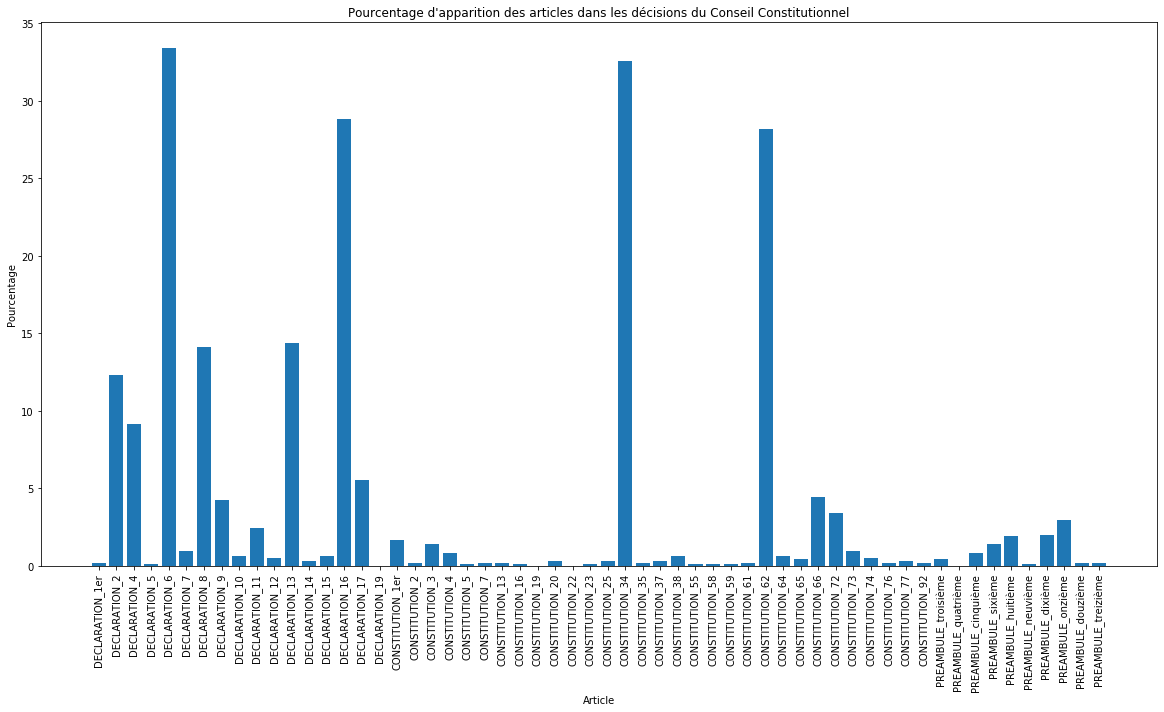

In [24]:
bar = 100 * data_cons_cons.iloc[:, 4:].sum() / len(data_cons_cons)

plt.figure(figsize = (20, 10))
plt.bar(bar.index, bar.values)
plt.title('Pourcentage d\'apparition des articles dans les décisions du Conseil Constitutionnel')
plt.xticks(rotation = 'vertical')
plt.xlabel('Article')
plt.ylabel('Pourcentage')
plt.show()

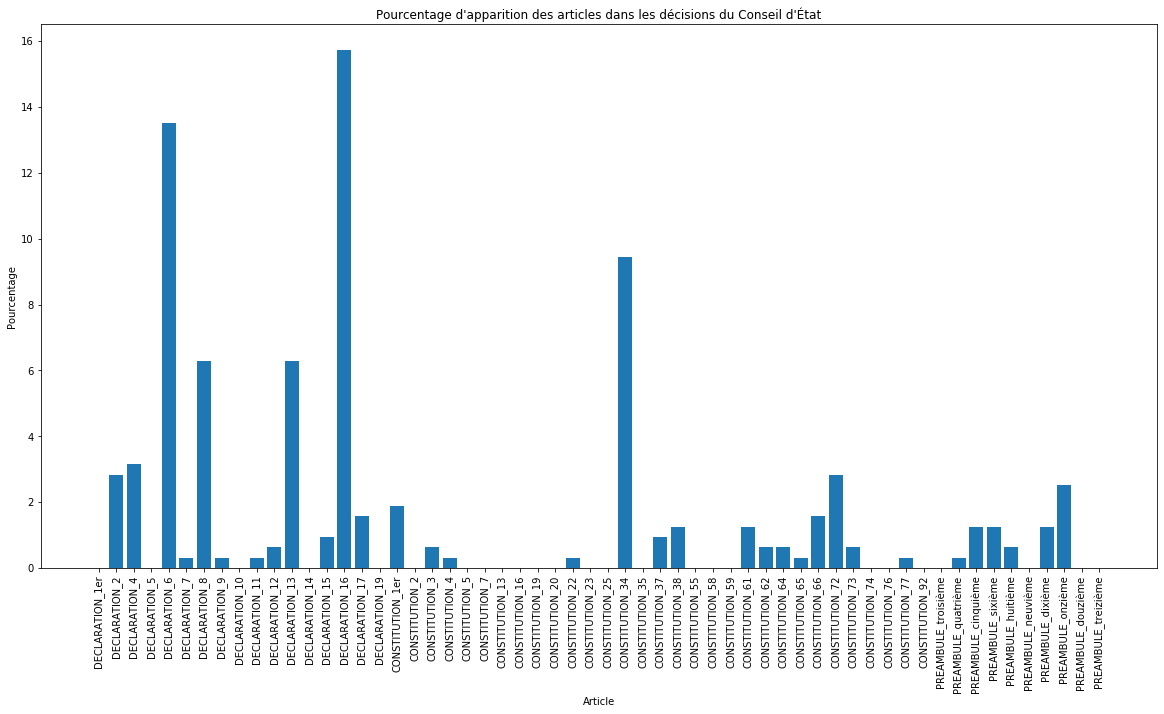

In [25]:
bar = 100 * data_cons_etat.iloc[:, 4:].sum() / len(data_cons_etat)

plt.figure(figsize = (20, 10))
plt.bar(bar.index, bar.values)
plt.title('Pourcentage d\'apparition des articles dans les décisions du Conseil d\'État')
plt.xticks(rotation = 'vertical')
plt.xlabel('Article')
plt.ylabel('Pourcentage')
plt.show()

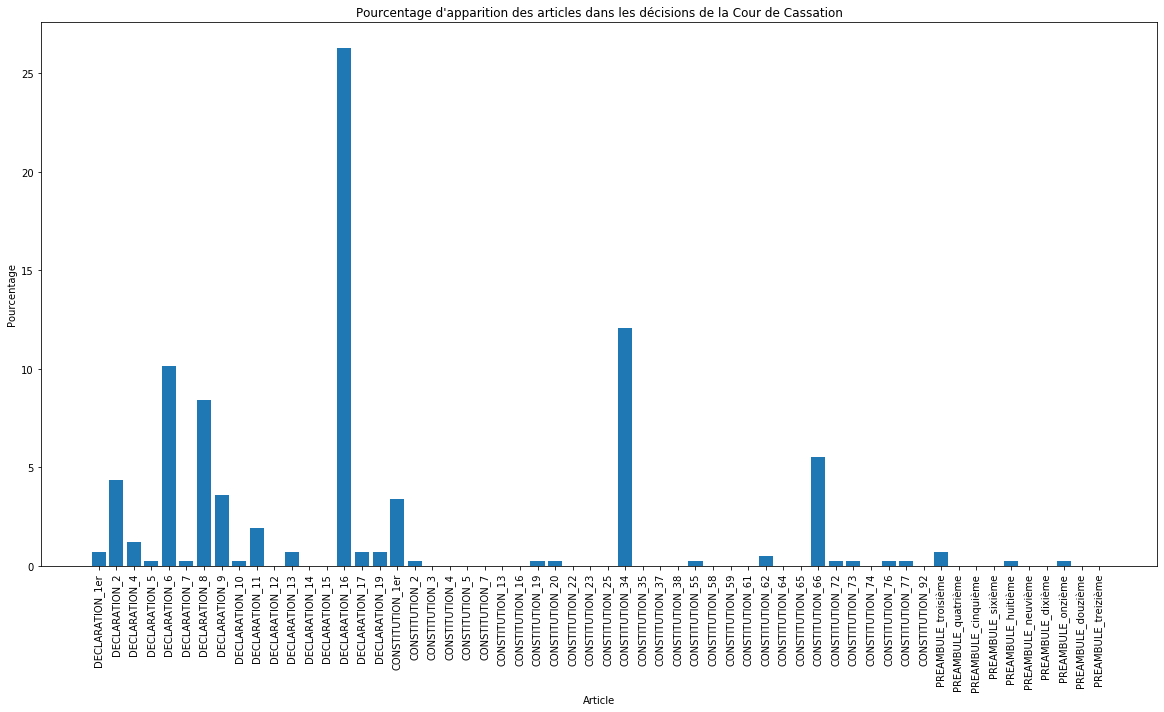

In [26]:
bar = 100 * data_cour_cass.iloc[:, 4:].sum() / len(data_cour_cass)

plt.figure(figsize = (20, 10))
plt.bar(bar.index, bar.values)
plt.title('Pourcentage d\'apparition des articles dans les décisions de la Cour de Cassation')
plt.xticks(rotation = 'vertical')
plt.xlabel('Article')
plt.ylabel('Pourcentage')
plt.show()

Nous observons qu'hormis les articles 34, 62 et 66 de la Constitution, la très grande majorité des articles du bloc de constitutionnalité cités dans les décisions proviennent de la Déclaration des Droits de l'Homme et du Citoyen. Pour des raisons de lisibilité, nous nous concentrerons donc sur ces articles dans la suite de notre analyse.

### 3.2 Distribution des articles par solutions

Nous analysons maintenant pour chaque juridiction les différences entre les distributions des articles dans les décisions qui ont obtenu un succès (un renvoi ou une non-conformité) et celles qui ont obtenu un échec (un non renvoi ou une conformité).

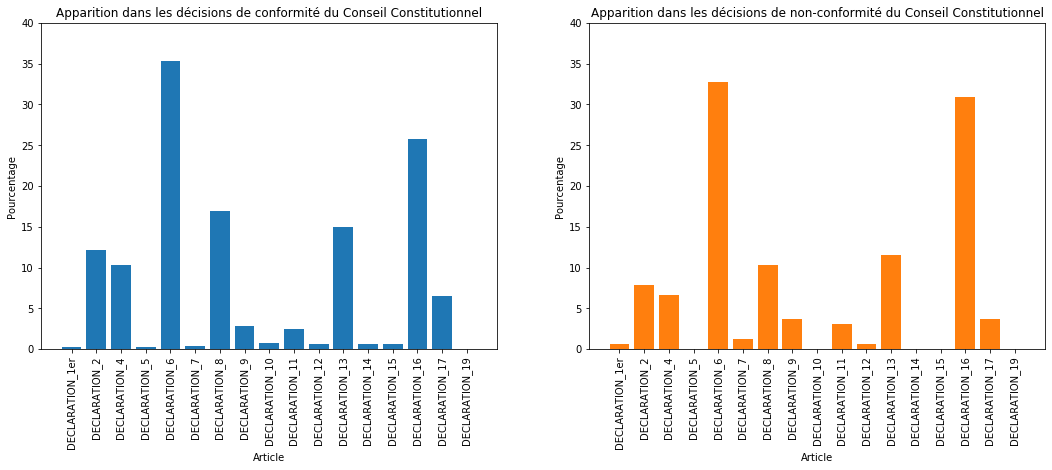

In [27]:
plt.figure(figsize = (18, 6))

bar = 100 * (data_cons_cons[data_cons_cons['SOLUTION'] == 'Conformité'].iloc[:, 4:21].sum() /
             len(data_cons_cons[data_cons_cons['SOLUTION'] == 'Conformité']))

plt.subplot(1, 2, 1)
plt.bar(bar.index, bar.values, color = 'tab:blue')
plt.title('Apparition dans les décisions de conformité du Conseil Constitutionnel')
plt.xticks(rotation = 'vertical')
plt.xlabel('Article')
plt.ylabel('Pourcentage')
plt.ylim(0, 40)

bar = 100 * (data_cons_cons[data_cons_cons['SOLUTION'] == 'Non-conformité'].iloc[:, 4:21].sum() /
             len(data_cons_cons[data_cons_cons['SOLUTION'] == 'Non-conformité']))

plt.subplot(1, 2, 2)
plt.bar(bar.index, bar.values, color = 'tab:orange')
plt.title('Apparition dans les décisions de non-conformité du Conseil Constitutionnel')
plt.xticks(rotation = 'vertical')
plt.xlabel('Article')
plt.ylabel('Pourcentage')
plt.ylim(0, 40)

plt.show()

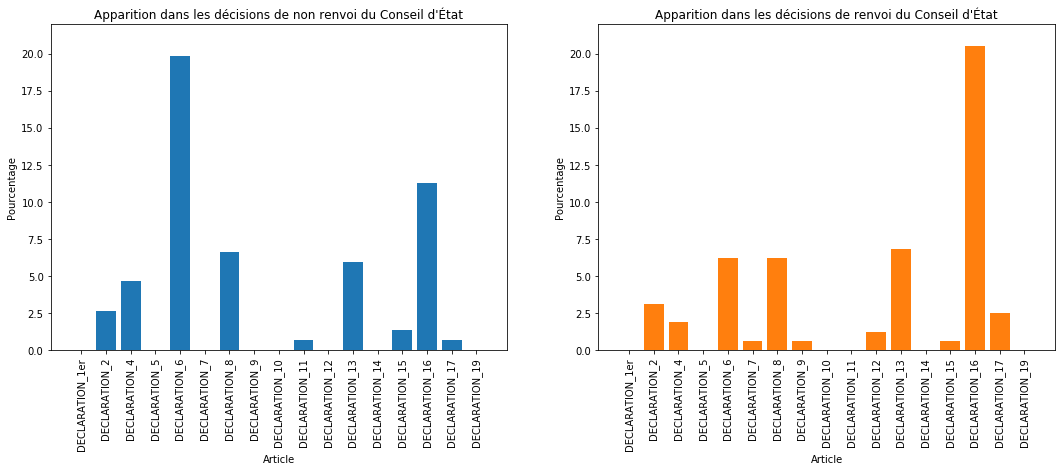

In [28]:
plt.figure(figsize = (18, 6))

bar = 100 * (data_cons_etat[data_cons_etat['SOLUTION'] == 'Non renvoi'].iloc[:, 4:21].sum() /
             len(data_cons_etat[data_cons_etat['SOLUTION'] == 'Non renvoi']))

plt.subplot(1, 2, 1)
plt.bar(bar.index, bar.values, color = 'tab:blue')
plt.title('Apparition dans les décisions de non renvoi du Conseil d\'État')
plt.xticks(rotation = 'vertical')
plt.xlabel('Article')
plt.ylabel('Pourcentage')
plt.ylim(0, 22)

bar = 100 * (data_cons_etat[data_cons_etat['SOLUTION'] == 'Renvoi'].iloc[:, 4:21].sum() /
             len(data_cons_etat[data_cons_etat['SOLUTION'] == 'Renvoi']))

plt.subplot(1, 2, 2)
plt.bar(bar.index, bar.values, color = 'tab:orange')
plt.title('Apparition dans les décisions de renvoi du Conseil d\'État')
plt.xticks(rotation = 'vertical')
plt.xlabel('Article')
plt.ylabel('Pourcentage')
plt.ylim(0, 22)

plt.show()

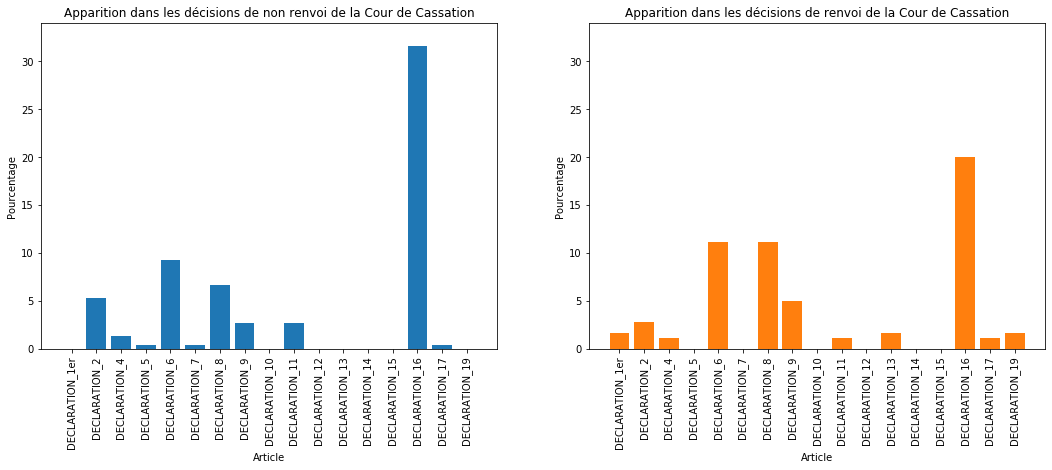

In [29]:
plt.figure(figsize = (18, 6))

bar = 100 * (data_cour_cass[data_cour_cass['SOLUTION'] == 'Non renvoi'].iloc[:, 4:21].sum() /
             len(data_cour_cass[data_cour_cass['SOLUTION'] == 'Non renvoi']))

plt.subplot(1, 2, 1)
plt.bar(bar.index, bar.values, color = 'tab:blue')
plt.title('Apparition dans les décisions de non renvoi de la Cour de Cassation')
plt.xticks(rotation = 'vertical')
plt.xlabel('Article')
plt.ylabel('Pourcentage')
plt.ylim(0, 34)

bar = 100 * (data_cour_cass[data_cour_cass['SOLUTION'] == 'Renvoi'].iloc[:, 4:21].sum() /
             len(data_cour_cass[data_cour_cass['SOLUTION'] == 'Renvoi']))

plt.subplot(1, 2, 2)
plt.bar(bar.index, bar.values, color = 'tab:orange')
plt.title('Apparition dans les décisions de renvoi de la Cour de Cassation')
plt.xticks(rotation = 'vertical')
plt.xlabel('Article')
plt.ylabel('Pourcentage')
plt.ylim(0, 34)

plt.show()

Nous pouvons émettre quelques observations. Par exemple, il semble que les décisions de non renvoi du Conseil d'État sont plutôt basées sur l'article 6 de la DDHC, tandis que ses décisions de renvoi ont tendance à citer l'article 16 de la DDHC. Cependant il est difficile d'en conclure une relation de causalité. Nous allons maintenant analyser la situation du point de vue inverse.  

### 3.3 Distribution des solutions par articles

Nous allons calculer pour chaque article sa probabilité empirique de mener à un succès ou à un échec lorsqu'il est utilisé. Afin d'en tirer des conclusions intéressantes, nous comparerons cette probabilité à la probabilité moyenne de succès ou d'échec de la juridiction en question.

In [30]:
data_cons_cons = data_cons_cons.loc[data_cons_cons['SOLUTION'] != 'N/A']
data_cons_etat = data_cons_etat.loc[data_cons_etat['SOLUTION'] != 'N/A']
data_cour_cass = data_cour_cass.loc[data_cour_cass['SOLUTION'] != 'N/A']

In [31]:
def get_distribution(data, failure, success):
    
    articles = ['MOYENNE'] + ['DECLARATION_' + art for art in art_declaration]
    dist_articles = pd.DataFrame(index = articles, columns = [failure, success, 'Nombre Décisions'])
    
    for art in articles:
        solutions_art = data[data[art] == 1]['SOLUTION']
        prob_art = solutions_art.value_counts(normalize = True).reindex([failure, success])
        dist_articles.loc[art, [failure, success]] = prob_art.fillna(0).values.T
        dist_articles.loc[art, 'Nombre Décisions'] = len(solutions_art)
    
    return dist_articles

In [32]:
dist_cons_cons = get_distribution(data_cons_cons, 'Conformité', 'Non-conformité')
dist_cons_etat = get_distribution(data_cons_etat, 'Non renvoi', 'Renvoi')
dist_cour_cass = get_distribution(data_cour_cass, 'Non renvoi', 'Renvoi')

Nous pouvons visualiser par exemple le dataframe du Conseil Constitutionnel.

In [33]:
dist_cons_cons

,Conformité,Non-conformité,Nombre Décisions
MOYENNE,0.759475,0.240525,686
DECLARATION_1er,0.5,0.5,2
DECLARATION_2,0.828947,0.171053,76
DECLARATION_4,0.830769,0.169231,65
DECLARATION_5,1,0,1
DECLARATION_6,0.773109,0.226891,238
DECLARATION_7,0.5,0.5,4
DECLARATION_8,0.838095,0.161905,105
DECLARATION_9,0.714286,0.285714,21
DECLARATION_10,1,0,4


Nous pouvons ainsi représenter sur des graphiques les probabilités d'échec et de succès de la demande, en moyenne et selon l'article utilisé (pour les articles cités dans au moins une dizaine de décisions) pour chaque juridiction.

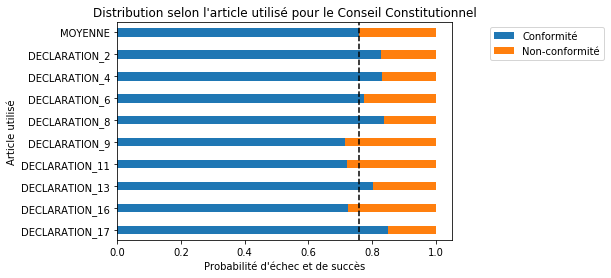

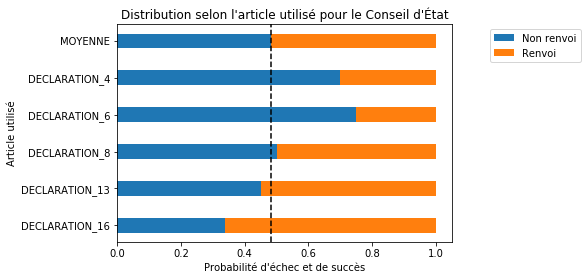

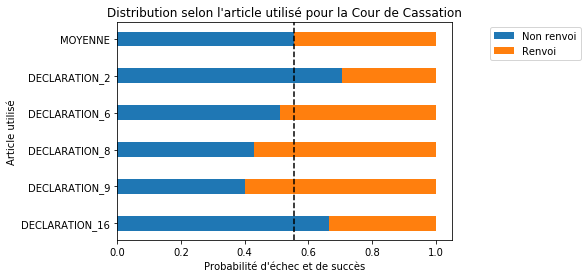

In [34]:
graph = dist_cons_cons[dist_cons_cons['Nombre Décisions'] >= 10][::-1]
graph[['Conformité', 'Non-conformité']].plot(kind = 'barh', stacked = True, width = 0.4)
plt.axvline(graph.loc['MOYENNE', 'Conformité'], linestyle = '--', color = 'black')
plt.legend(loc = 'upper left', bbox_to_anchor = (1.10, 1))
plt.title('Distribution selon l\'article utilisé pour le Conseil Constitutionnel')
plt.xlabel('Probabilité d\'échec et de succès')
plt.ylabel('Article utilisé')
plt.show()

graph = dist_cons_etat[dist_cons_etat['Nombre Décisions'] >= 10][::-1]
graph[['Non renvoi', 'Renvoi']].plot(kind = 'barh', stacked = True, width = 0.4)
plt.axvline(graph.loc['MOYENNE', 'Non renvoi'], linestyle = '--', color = 'black')
plt.legend(loc = 'upper left', bbox_to_anchor = (1.10, 1))
plt.title('Distribution selon l\'article utilisé pour le Conseil d\'État')
plt.xlabel('Probabilité d\'échec et de succès')
plt.ylabel('Article utilisé')
plt.show()

graph = dist_cour_cass[dist_cour_cass['Nombre Décisions'] >= 10][::-1]
graph[['Non renvoi', 'Renvoi']].plot(kind = 'barh', stacked = True, width = 0.4)
plt.axvline(graph.loc['MOYENNE', 'Non renvoi'], linestyle = '--', color = 'black')
plt.legend(loc = 'upper left', bbox_to_anchor = (1.10, 1))
plt.title('Distribution selon l\'article utilisé pour la Cour de Cassation')
plt.xlabel('Probabilité d\'échec et de succès')
plt.ylabel('Article utilisé')
plt.show()

Ainsi, il semble qu'une demande basée sur l'article 16 de la DDHC a plus de chance d'obtenir un succès au Conseil d'État, à l'inverse d'une demande basée sur l'article 6; de même, qu'une demande basée sur l'article 9 de la DDHC a plus de chance d'obtenir un succès à la Cour de Cassation, à l'inverse d'une demande basée sur l'article 2.

Il faut toutefois prendre ces résultats avec des précautions, car même dans la situation où tous les articles auraient la même probabilité d'obtenir un succès, il y aurait des fluctuations aléatoires autour de la probabilité moyenne. Un approfondissement possible serait l'étude de la significativité statistique de nos résultats.

Nous pouvons enfin réaliser les mêmes calculs pour le parcours complet d'une demande, en approximant la probabilité de succès d'une demande initiale comme sa probabilité de renvoi par la première juridiction (Conseil d'État ou Cour de Cassation) multipliée par sa probabilité d'être déclarée non-conforme par le Conseil Constitutionnel.

In [35]:
dist_parc_complet = get_distribution(data_cons_etat.append(data_cour_cass), 'Non renvoi', 'Renvoi')
dist_parc_complet['Nombre Décisions CC'] = dist_cons_cons['Nombre Décisions']
dist_parc_complet['Succès'] = dist_parc_complet['Renvoi'] * dist_cons_cons['Non-conformité']
dist_parc_complet['Échec'] = 1 - dist_parc_complet['Succès']

In [36]:
dist_parc_complet

,Non renvoi,Renvoi,Nombre Décisions,Nombre Décisions CC,Succès,Échec
MOYENNE,0.524407,0.475593,717,686,0.114392,0.885608
DECLARATION_1er,0,1,3,2,0.5,0.5
DECLARATION_2,0.615385,0.384615,26,76,0.0657895,0.934211
DECLARATION_4,0.666667,0.333333,15,65,0.0564103,0.94359
DECLARATION_5,1,0,1,1,0,1
DECLARATION_6,0.62963,0.37037,81,238,0.0840336,0.915966
DECLARATION_7,0.5,0.5,2,4,0.25,0.75
DECLARATION_8,0.454545,0.545455,55,105,0.0883117,0.911688
DECLARATION_9,0.375,0.625,16,21,0.178571,0.821429
DECLARATION_10,0,0,0,4,0,1


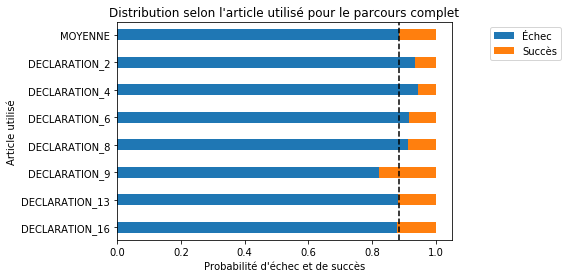

In [37]:
graph = dist_parc_complet[(dist_parc_complet['Nombre Décisions'] >= 10) &
                          (dist_parc_complet['Nombre Décisions CC'] >= 10)][::-1]
graph[['Échec', 'Succès']].plot(kind = 'barh', stacked = True, width = 0.4)
plt.axvline(graph.loc['MOYENNE', 'Échec'], linestyle = '--', color = 'black')
plt.legend(loc = 'upper left', bbox_to_anchor = (1.10, 1))
plt.title('Distribution selon l\'article utilisé pour le parcours complet')
plt.xlabel('Probabilité d\'échec et de succès')
plt.ylabel('Article utilisé')
plt.show()

Notre conclusion finale, aux significativités statistiques près, est donc qu'une question prioritaire de constitutionnalité basée sur l'article 9 de la DDHC a près de deux fois plus de chance d'obtenir un succès que la moyenne, tandis qu'une question prioritaire de constitutionnalité basée sur l'article 4 de la DDHC a près de deux fois moins de chance d'obtenir un succès que la moyenne.

Ce genre de résultats pourraient ainsi aider un avocat à décider ou non de se lancer dans la démarche de rédaction d'une question prioritaire de constitutionnalité qui serait utile à un dossier, selon l'article sur lequel elle est basée.